In [1]:
# importing the dependencies modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tqdm import tqdm
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore")

# The code will allow you to switch between the dark and light mode in graphs
from matplotlib import cycler

colors = cycler('color', ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor='#313233', edgecolor='None', axisbelow=True, grid=True, prop_cycle=colors, labelcolor='gray')

plt.rc('grid', color='#47a4a4')  #, linestlye='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor='#313233', edgecolor='#313233')
plt.rc('text', color='#c9c9c9')

In [2]:
# Sortino Ratio
# Prepare data
data = yf.download('GOOG', end='2021-01-01')
return_series = data['Adj Close'].pct_change()
return_series.name = 'return'

# compute the sortino ratio
volatility = return_series[return_series < 0].std()
mean = return_series.mean()

# sortino ratio is the ratio of the mean return to the volatility of the negative returns
sortino_ration = np.sqrt(252) * mean / volatility  # 252 is trading days in a year

print(f"Sortino: {np.round(sortino_ration, 3)}")

[*********************100%***********************]  1 of 1 completed
Sortino: 1.232


In [3]:
# Beta Calculation
# We need to compute the covariance between the market and the portfolio
sp500 = yf.download('^GSPC')['Adj Close'].pct_change()
sp500.name = 'SP500'

# We concatenate the two dataframe
value = pd.concat([return_series, sp500], axis=1).dropna()

# We compute the beta
covariance = np.cov(value[['return', 'SP500']].values, rowvar=False)[0][1]
variance = np.var(value['SP500'].values)
beta = covariance / variance

print(f'Beta: {np.round(beta, 3)}')

[*********************100%***********************]  1 of 1 completed
Beta: 0.965


In [4]:
# Alpha Calculation
# We compute the alpha
mean = return_series.mean()
alpha = 252 * (mean - beta * mean)  # 252 trading days in a year
print(f'Alpha: {np.round(alpha * 100, 5)}%')

Alpha: 0.91785%


In [5]:
# Drawdown function
# We compute the drawdown i.e risk of the strategy
def drawdown_fun(series):
	cumulative_sum = series.dropna().cumsum() + 1  # multiplication coefficient

	# compute the max of the cumulative_sum
	# (1,3,1,1,7,1,2,) -> (1,3,3,3,7,7,7)
	running_max = np.maximum.accumulate(cumulative_sum)

	# compute the drawdown
	drawdowned = cumulative_sum / running_max - 1
	return drawdowned

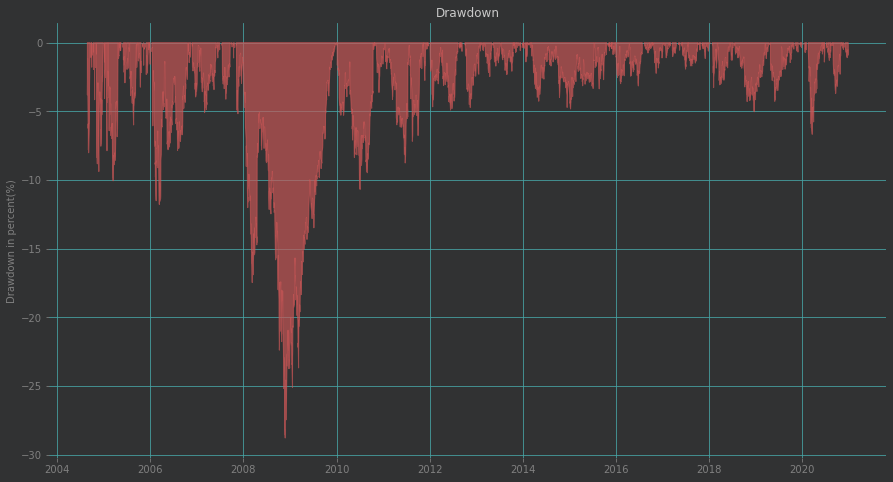

In [6]:
# drawdown calculation
drawdown = drawdown_fun(return_series)

# Plot the figure
plt.figure(figsize=(15, 8))

# Plot the drawdown
plt.fill_between(drawdown.index, drawdown * 100, 0, drawdown < 0, color='#CE5757', alpha=0.65)

# Title and labels
plt.title('Drawdown')
plt.ylabel('Drawdown in percent(%)')
plt.show()

In [7]:
# Computation of max drawdown
max_drawdown = -np.min(drawdown) * 100

print(f'Max drawdown: {np.round(max_drawdown, 1)}%')

Max drawdown: 28.8%
